# Module 3 Homework — Full EDA on NOAA NDBC Buoy 44013

Dataset:
- **Station:** 44013  
- **Granularity:** ~10-minute observations  
- **Coverage:** ~46 days (your run may differ slightly)  
- **Input file:** curated parquet table, `data/warehouse/ndbc_curated_44013.parquet` (written by your Module 2 NOAA pipeline)

**Your job (homework):** perform a complete EDA and write a short narrative:
- what’s typical, what’s variable, what’s risky (tails/outliers)
- what differs by time-of-day / day-of-week
- what variables move together (and why “together” ≠ “causes”)
- 3–6 hypotheses you would investigate next
- 1–2 simple inference checks (bootstrap CIs) to quantify uncertainty


## 0) Setup

In [2]:
from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 180)


## 1) Load curated data (Module 2 NOAA HW output)

**Task (homework):**
1. Locate the curated parquet for station 44013.
2. Load it into a dataframe.
3. Confirm row count, column list, and time range.

**Expected columns (from your pipeline):**
`station_id, time_utc, obs_day, obs_hour, dayofweek, is_weekend, wind_high, temp_gap_c, WSPD, GST, WVHT, DPD, APD, PRES, ATMP, WTMP, WDIR`


In [3]:
# Paths from Module 2 NOAA homework


Looking for: /home/jupyter-kerblesl@isu.edu/work/homework_2_noaa/data/warehouse/ndbc_curated_44013.parquet
Exists? True


Shape: (6470, 17)


,station_id,time_utc,obs_day,obs_hour,dayofweek,is_weekend,wind_high,temp_gap_c,WSPD,GST,WVHT,DPD,APD,PRES,ATMP,WTMP,WDIR
0,44013,2026-01-25 05:40:00+00:00,2026-01-25,5,6,1,0,-15.3,9.0,12.0,NaN,NaN,NaN,1037.3,-10.4,4.9,330.0
1,44013,2026-01-25 05:30:00+00:00,2026-01-25,5,6,1,0,-15.3,10.0,12.0,NaN,NaN,NaN,1037.3,-10.4,4.9,330.0
2,44013,2026-01-25 05:20:00+00:00,2026-01-25,5,6,1,0,-15.1,9.0,12.0,1.2,5.0,3.8,1037.2,-10.2,4.9,330.0
3,44013,2026-01-25 05:10:00+00:00,2026-01-25,5,6,1,0,-15.0,9.0,12.0,NaN,NaN,NaN,1037.4,-10.1,4.9,330.0
4,44013,2026-01-25 05:00:00+00:00,2026-01-25,5,6,1,0,-15.0,9.0,12.0,NaN,NaN,NaN,1037.4,-10.2,4.8,320.0


### Quick schema + sanity checks

In [5]:
# Basic schema checks


# Time range


# Uniqueness expectations (10-min data can have duplicates if ingest merges)
# We'll treat duplicates as a data-quality investigation, not auto-deletion.



Columns: ['station_id', 'time_utc', 'obs_day', 'obs_hour', 'dayofweek', 'is_weekend', 'wind_high', 'temp_gap_c', 'WSPD', 'GST', 'WVHT', 'DPD', 'APD', 'PRES', 'ATMP', 'WTMP', 'WDIR']

Dtypes:


station_id                 object
time_utc      datetime64[ns, UTC]
obs_day                    object
obs_hour                    int32
dayofweek                   int32
is_weekend                  int64
wind_high                   int64
temp_gap_c                float64
WSPD                      float64
GST                       float64
WVHT                      float64
DPD                       float64
APD                       float64
PRES                      float64
ATMP                      float64
WTMP                      float64
WDIR                      float64
dtype: object


Time range: 2025-12-11 00:00:00+00:00 → 2026-01-25 05:40:00+00:00

Duplicate (station_id, time_utc) rows: 0


In [6]:
# Missingness snapshot



,column,pct_missing
0,DPD,67.22
1,APD,59.80
2,WVHT,59.80
3,temp_gap_c,1.30
4,WTMP,1.21
5,WDIR,0.34
6,ATMP,0.15
7,GST,0.09
8,WSPD,0.09
9,PRES,0.05


**Interpretation:**
- Missingness is common in marine sensors (e.g., wave period fields may drop out).
- Treat missingness as *structure* (when/why data disappears), not just “holes to fill”.


## 2) Descriptive statistics

**Task (homework):**
Pick 3–5 “core variables” and produce:
- center (mean/median)
- spread (IQR, std, p90/p95/p99)
- a quick interpretation: what is “typical” and what is “tail risk”?

Suggested core variables:
- `WSPD` (wind speed), `GST` (gust), `WVHT` (wave height)
- `ATMP` (air temp), `WTMP` (water temp), `PRES` (pressure)


,n,mean,median,std,iqr,p90,p95,p99,min,max
WSPD,6464.0,7.937809,8.0,3.233092,4.0,13.0,14.0,15.000,0.0,19.0
GST,6464.0,10.272896,10.0,4.170930,6.0,16.0,18.0,20.000,0.0,25.0
WVHT,2601.0,0.983852,0.9,0.514364,0.7,1.6,2.0,2.700,0.2,3.2
ATMP,6460.0,1.054087,1.2,4.223476,5.7,6.5,7.4,9.141,-12.7,12.4
WTMP,6392.0,6.446762,6.1,1.029485,1.8,7.9,8.2,8.600,4.8,8.6
PRES,6467.0,1013.714350,1015.6,9.607554,12.5,1025.3,1028.0,1034.034,987.0,1037.9


**Interpretation prompts:**
- Which variables are heavy-tailed? (p99 ≫ median)
- Are there physically implausible values? (e.g., negative wave height)
- Do “typical” values match your intuition about winter offshore conditions?


## 3) Visualization as thinking

In **3.A**, you practiced the “histogram + log view + boxplot” pattern.
Here we apply it to NOAA buoy variables.

**Task (homework):**
1. Plot distributions (ie for `WSPD` and `WVHT`) -- include a log-like view if needed.
2. Plot time series (ie for `WSPD` and `WVHT`) to see regime changes / storm events.
3. Write 2–3 bullets: what do the plots reveal that a table hid?


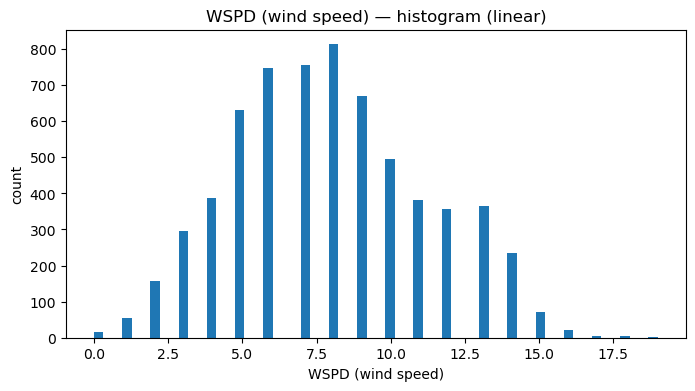

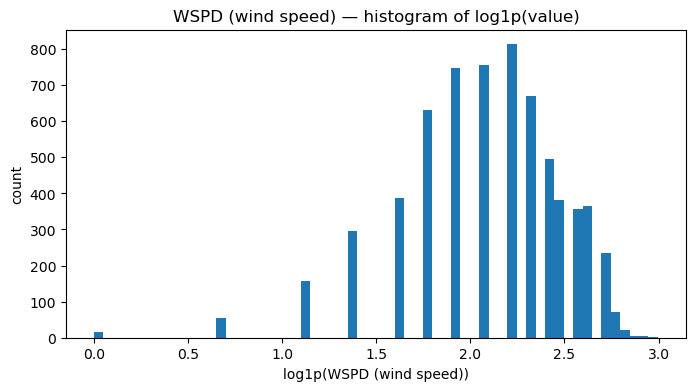

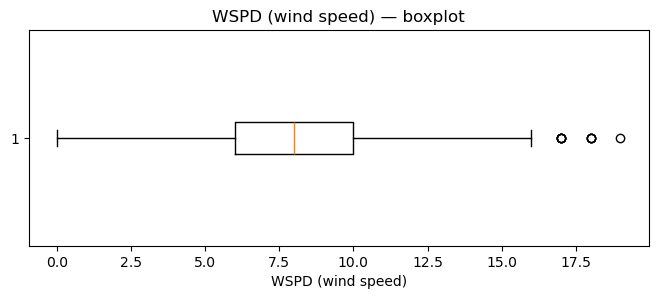

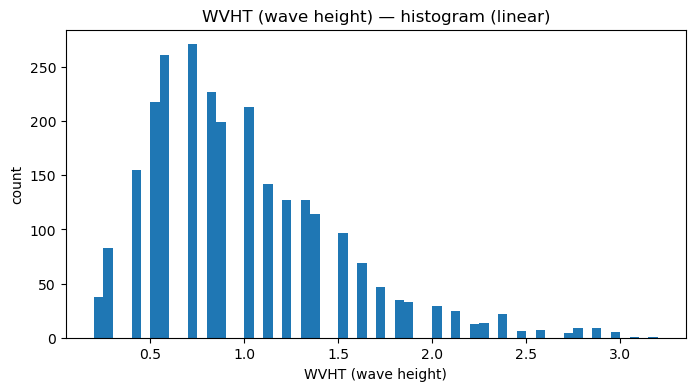

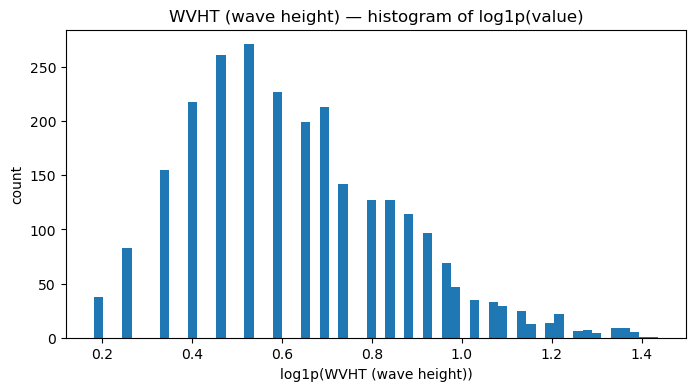

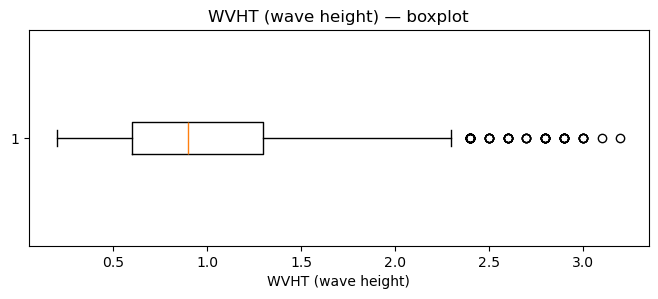

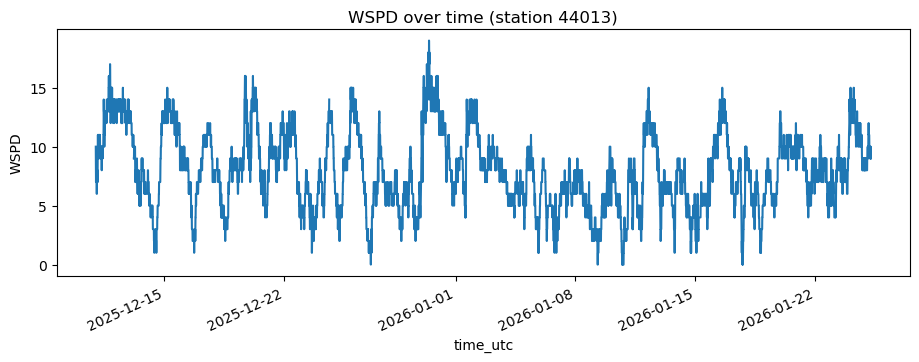

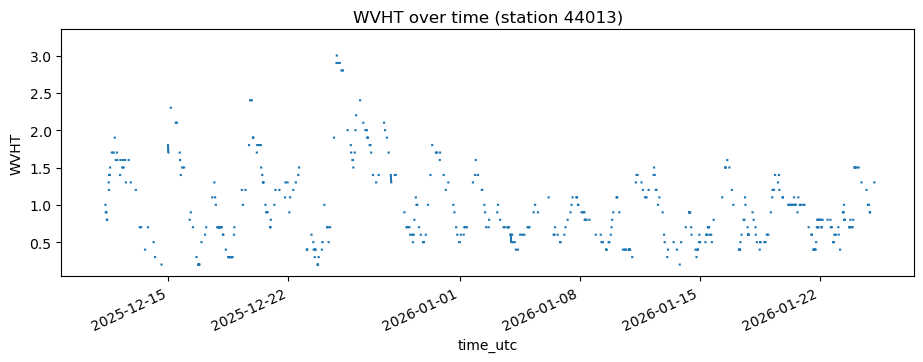

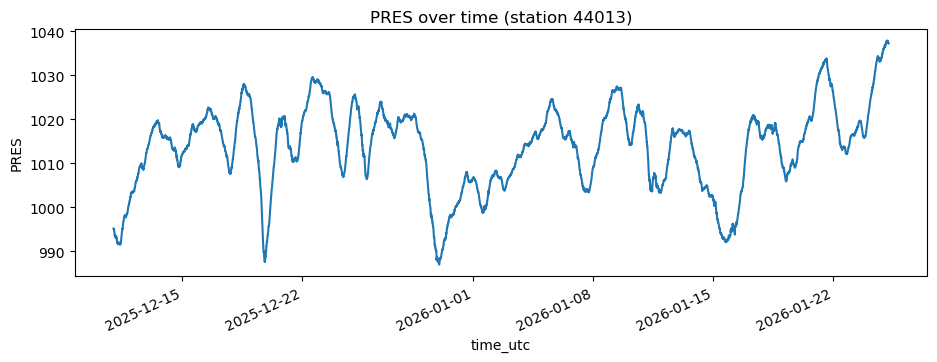

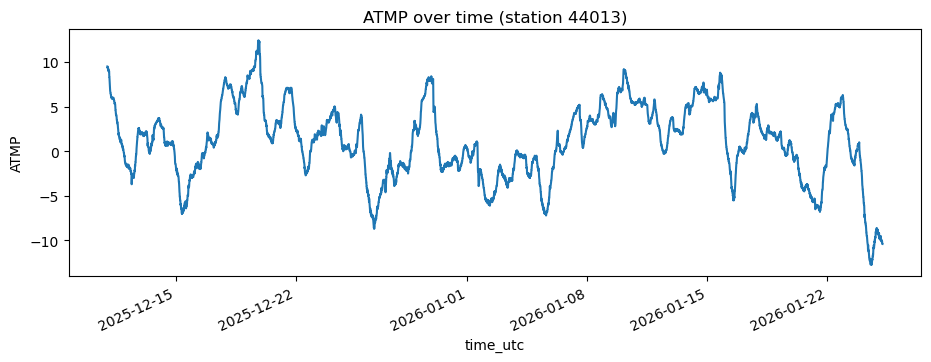

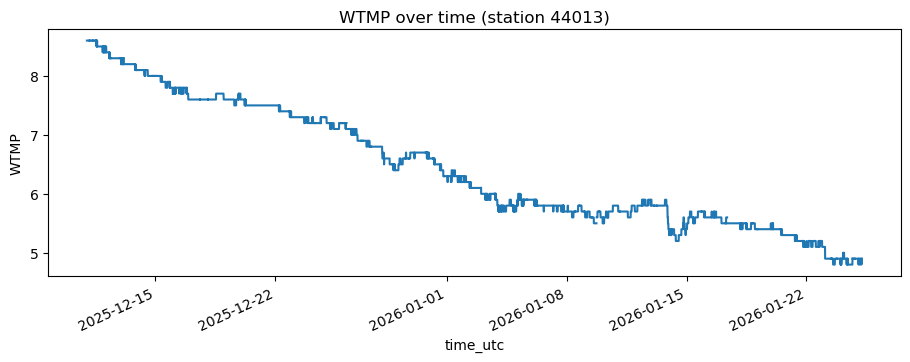

In [9]:
# Time series: use time_utc as the x-axis



## 4) Group comparisons

Group comparisons turn “overall” into something actionable.

**Task (homework):**
1. Compare `WVHT` and `WSPD` by **day-of-week** and **weekend vs weekday**.
2. Compare by **hour of day** to see diurnal patterns (if any).
3. Summarize using **median + p95** (tail risk), not just mean.


In [10]:


# Weekend vs weekday summary



Time feature columns present: ['obs_hour', 'dayofweek', 'is_weekend']


,p50,p90,p95,p99,n
is_weekend,,,,,
0,8.0,13.0,14.0,15.0,4572
1,7.0,12.0,13.0,14.0,1892


,p50,p90,p95,p99,n
is_weekend,,,,,
0,0.9,1.8,2.100,2.8,1857
1,0.9,1.5,1.685,2.0,744


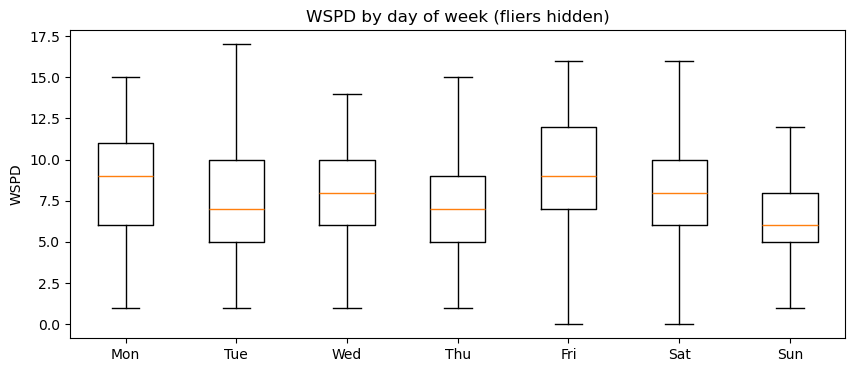

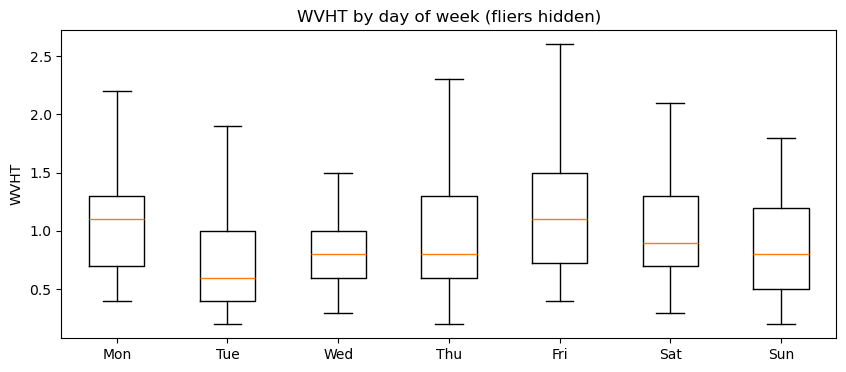

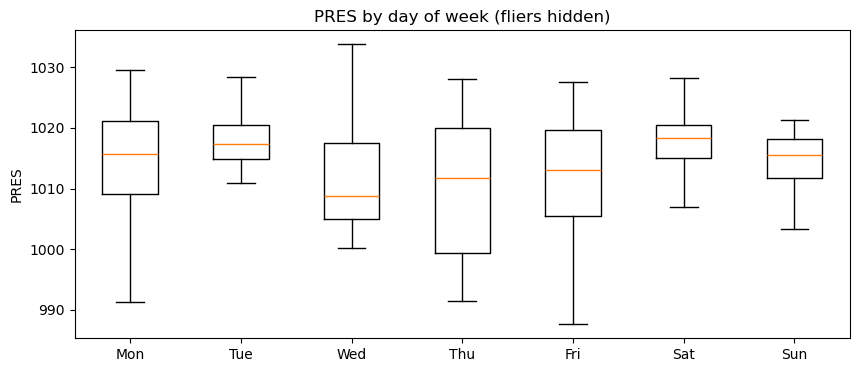

In [11]:
# Boxplots by dayofweek



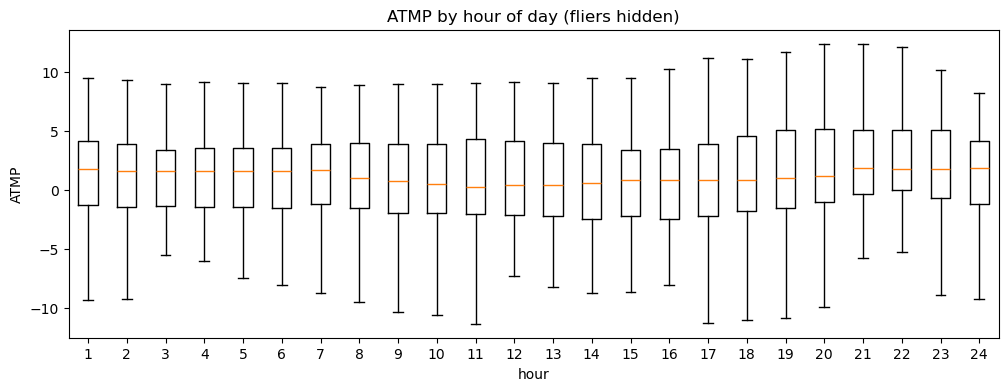

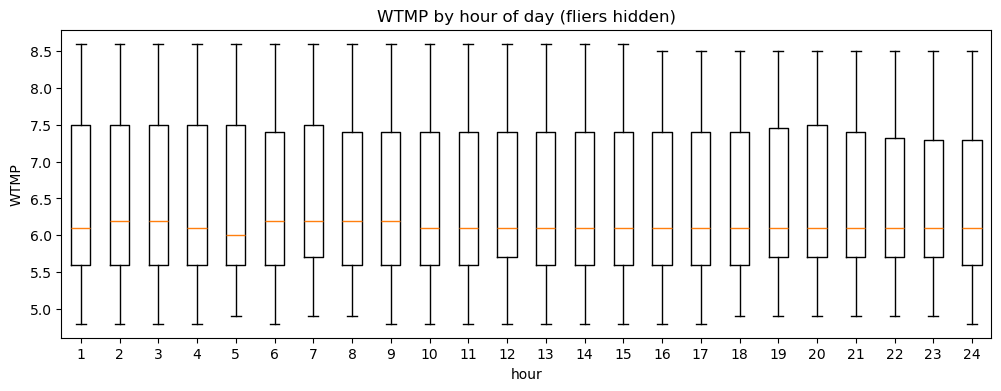

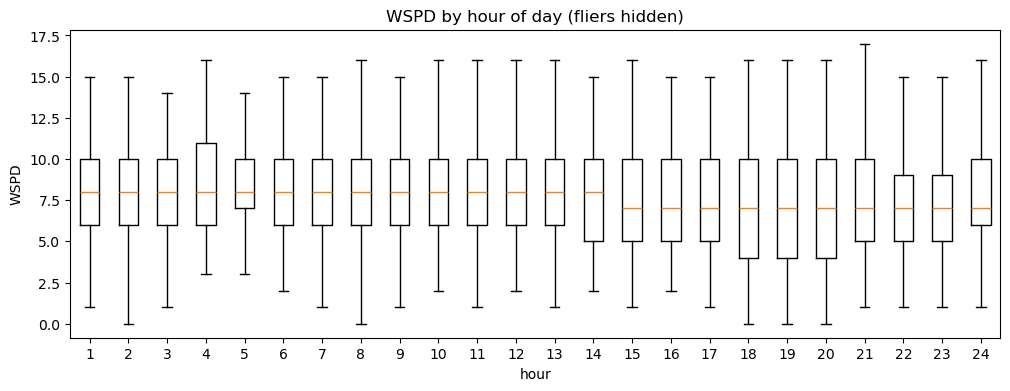

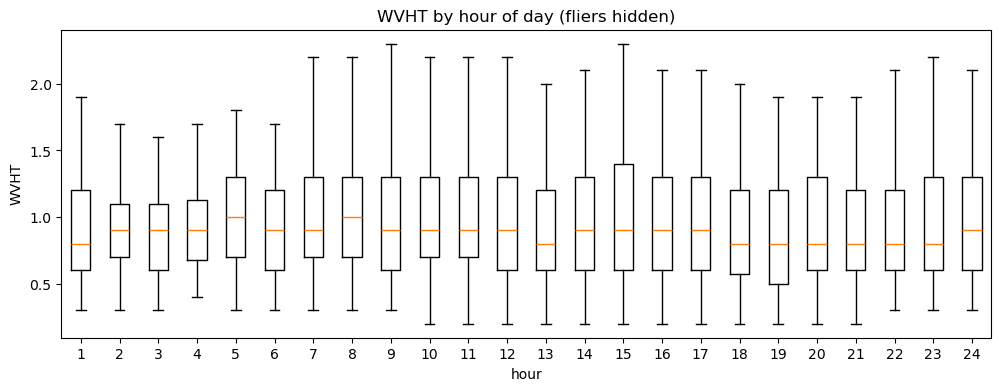

In [18]:
# Hour-of-day effects (boxplot)
# Remember this is by utc hour



## 5) Correlation vs causation (EDA hygiene)

**Task (homework):**
1. Compute a correlation matrix for the numeric variables.
2. Visualize it.
3. Pick 2 correlations that look “strong” and write:
   - a causal story that *could* be true
   - a confounder story that could also explain it
   - one follow-up check you’d run next

> Example: `WSPD` and `WVHT` often move together, but the *real cause* might be an underlying storm system.


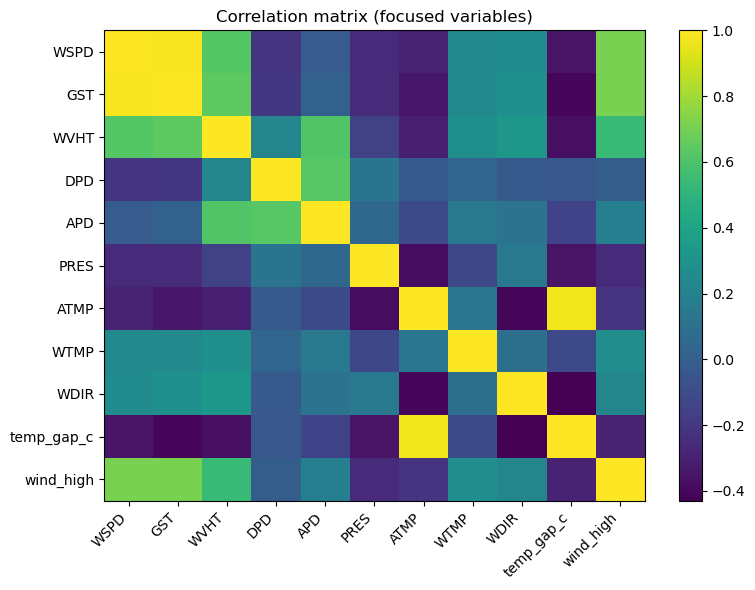

,WSPD,GST,WVHT,DPD,APD,PRES,ATMP,WTMP,WDIR,temp_gap_c,wind_high
WSPD,1.000000,0.983697,0.622211,-0.214599,-0.016634,-0.261468,-0.290859,0.246473,0.262663,-0.352559,0.710438
GST,0.983697,1.000000,0.643327,-0.200254,0.013538,-0.245868,-0.339607,0.252417,0.289443,-0.402466,0.713968
WVHT,0.622211,0.643327,1.000000,0.223222,0.612834,-0.147267,-0.302543,0.282055,0.324852,-0.373500,0.540948
DPD,-0.214599,-0.200254,0.223222,1.000000,0.627719,0.123034,-0.029899,0.037866,-0.030033,-0.038887,-0.006859
APD,-0.016634,0.013538,0.612834,0.627719,1.000000,0.050589,-0.108126,0.143697,0.117225,-0.143054,0.184927
PRES,-0.261468,-0.245868,-0.147267,0.123034,0.050589,1.000000,-0.382087,-0.119574,0.149742,-0.352203,-0.260822
ATMP,-0.290859,-0.339607,-0.302543,-0.029899,-0.108126,-0.382087,1.000000,0.132289,-0.405155,0.970203,-0.217313
WTMP,0.246473,0.252417,0.282055,0.037866,0.143697,-0.119574,0.132289,1.000000,0.096582,-0.111818,0.273093
WDIR,0.262663,0.289443,0.324852,-0.030033,0.117225,0.149742,-0.405155,0.096582,1.000000,-0.429674,0.226425
temp_gap_c,-0.352559,-0.402466,-0.373500,-0.038887,-0.143054,-0.352203,0.970203,-0.111818,-0.429674,1.000000,-0.285556


In [13]:
# Correlation matrix on numeric columns



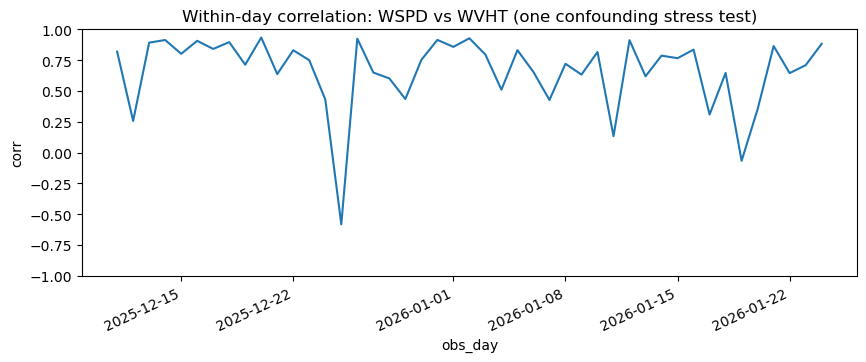

In [19]:
# A concrete "confounding" check: time can be a confounder.
# We'll look at correlations within each day (small multiple via summary), rather than overall.




## 6) Hypothesis generation backlog

EDA is not “done” when you have plots. It’s done when you have **next questions**.

**Task (homework):**
Write 5–10 hypotheses as a backlog. Each hypothesis should include:
- a claim (what might be true)
- what data/plot suggested it
- what check would reduce uncertainty

Below are example hypotheses for buoy 44013.


### Example hypothesis backlog

1. **Storm regimes exist**: there are distinct “quiet” vs “storm” periods visible in `WSPD` and `WVHT` time series.  
   **Check:** identify storm windows where `PRES` drops sharply; compare wind/wave distributions inside vs outside.

2. **Pressure drop precedes wave height spike** (time-lag relationship).  
   **Check:** compute cross-correlation or lagged scatter (e.g., `PRES(t-6h)` vs `WVHT(t)`).

3. **Weekend vs weekday differs** only because the time range includes a storm on a weekend (spurious group effect).  
   **Check:** recompute group differences after removing the top 2–3 storm days.


## 7) Inference intuition on EDA claims (bootstrap)

We’re not doing “formal hypothesis tests” yet. We’re building intuition for **uncertainty**.

**Task (homework):**
Pick two EDA claims and quantify them with a bootstrap confidence interval.

As an example we’ll do:
1) Difference in **median** wave height between high-wind vs low-wind conditions  
2) Correlation between wind speed and wave height (with uncertainty)


Rows for inference: 2598


WSPD thresholds: 5.0 (20%) and 11.0 (80%)
Low n: 633 High n: 577
Estimated median(WVHT) difference (high-low): 1.0
95% bootstrap CI: (0.8999999999999999, 1.0)


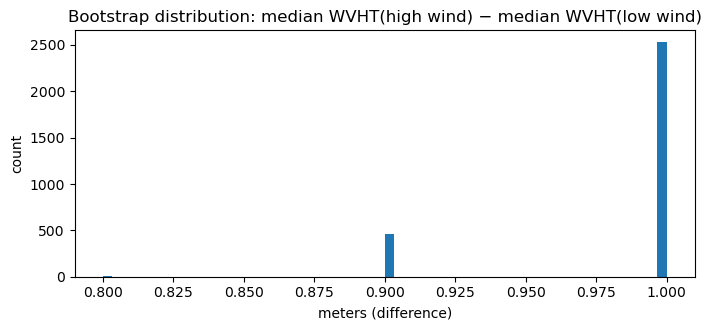

In [16]:
# 1) High wind vs low wind: difference in median WVHT
# Define "high wind" as top 20% of WSPD; "low wind" as bottom 20%.



Correlation estimate: 0.6222109861345583
95% bootstrap CI: (0.5858454865829911, 0.6558335829877102)


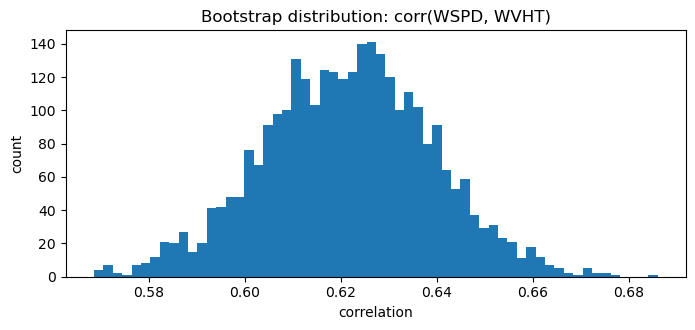

In [17]:
# 2) Bootstrap uncertainty for correlation corr(WSPD, WVHT)



## 8) Final deliverable (example structure)

Below is an example structure for a strong “final EDA write-up”. Your homework submission can follow this template.

### A) Orientation (3–5 bullets)
- Data source, station, time range, sampling cadence  
- Key variables used for analysis  
- Missingness summary: which sensors are incomplete and when

### B) What’s typical vs what’s risky (5–8 bullets)
- Typical wind speed and wave height (median)  
- Tail risk (p95/p99) and what that implies  
- Which variables are heavy-tailed and why that matters

### C) What varies by time/group (4–8 bullets)
- Day-of-week / weekend vs weekday differences (median and p95)  
- Hour-of-day patterns (if present)  
- Which differences might be real vs spurious (storm-days confounding)

### D) Relationships and caveats (4–8 bullets)
- Strong correlations observed (e.g., WSPD ↔ WVHT)  
- Causation caveats and confounders (storms, seasonality, sensor dropout)  
- One additional check you ran to stress-test a causal story

### E) Inference intuition (2–4 bullets)
- One bootstrap CI and what it says about uncertainty  
- What you would need for stronger claims

### F) Hypothesis backlog (5–10 items)
- Clear next questions + proposed checks
